<font size="9">Kernel Functions Profiling</font><br>
<hr>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from conf import LisaLogging
LisaLogging.setup()

In [3]:
# Generate plots inline
%pylab inline

import json
import os

import re
import collections
import pandas

# Support to tests execution
from executor import Executor
from env import TestEnv

Populating the interactive namespace from numpy and matplotlib


# Tests configuration

In [4]:
# Setup a target configuration
target_conf = {

    # Platform and board to target
    "platform"    : "linux",
    "board"       : "juno",

    # Login credentials
    "host"        : "192.168.0.1",
    "username"    : "brendan",
    "password"    : "",

    # Local installation path
    "tftp"  : {
        "folder"    : "/var/lib/tftpboot",
        "kernel"    : "kern.bin",
        "dtb"       : "dtb.bin",
    },

    # RTApp calibration values (comment to let LISA do a calibration run)
    "rtapp-calib" :  {
        "0": 358, "1": 138, "2": 138, "3": 357, "4": 359, "5": 355
    },

}

test_conf = {
    # Tools to deploy
    "tools" : [ "rt-app", 'trace-cmd' ],
    
    # Where results are collected
    # NOTE: this folder will be wiped before running the experiments
    "results_dir" : "KernelFunctionsProfilingExample",

    # Modules required by these experiments
    "exclude_modules" : [ "hwmon" ],
    
    # Kernel functions to profile for all the test
    # configurations which have the "ftrace" flag enabled
    "ftrace"  : {
         "functions" : [
            "select_task_rq_fair",
            "enqueue_task_fair",
            "dequeue_task_fair",
         ],
         "buffsize" : 80 * 1024,
    },
}

env = TestEnv(target_conf, test_conf)

01:43:51  INFO    :         Target - Using base path: /home/bjackman/sources/lisa
01:43:51  INFO    :         Target - Loading custom (inline) target configuration
01:43:51  INFO    :         Target - Loading custom (inline) test configuration
01:43:51  INFO    :         Target - Devlib modules to load: ['bl', 'cpufreq']
01:43:51  INFO    :         Target - Connecting linux target:
01:43:51  INFO    :         Target -   username : brendan
01:43:51  INFO    :         Target -       host : 192.168.0.1
01:43:51  INFO    :         Target -   password : 
01:43:51  INFO    :         Target - Connection settings:
01:43:51  INFO    :         Target -    {'username': 'brendan', 'host': '192.168.0.1', 'password': ''}
01:43:58  INFO    :         Target - Initializing target workdir:
01:43:58  INFO    :         Target -    /home/brendan/devlib-target
01:44:04  INFO    :         Target - Topology:
01:44:04  INFO    :         Target -    [[0, 3, 4, 5], [1, 2]]
01:44:07  INFO    :       Platform - Lo

In [9]:
# Setup tests executions based on our configuration
    
tests_conf = {
    # Platform configurations to test
    "confs" : [
        {
            "tag"            : "base",
            "flags"          : "ftrace",
            "sched_features" : "NO_ENERGY_AWARE",
            "cpufreq"        : {
                "governor" : "performance",
            },
            # provide a set of files and values to write into them
            "files"          : {
                # if filenames start with !/ then we verify that the content
                # matches what we wrote and raise an exception if it does not.
                # All filenames without an initial decorator are not verified,
                # and we do not assert that the write was allowed
                # (i,e, the file existed, we have write permission, etc.)
                # this means we can use this for sysctls or other files whose
                # presence or permissions might depend upon kernel config or
                # OS support and we reasonably can proceed for either case.
                '/this_file_doesnt_exist_and_we_dont_care'     : '1',
                '/proc/sys/kernel/sched_is_big_little'          : '0',
                '/proc/sys/kernel/sched_initial_task_util'      : '1023',
                '/proc/sys/kernel/sched_use_walt_cpu_util'     : '0',
                '/proc/sys/kernel/sched_use_walt_task_util'    : '0',
                '/proc/sys/kernel/sched_cstate_aware'           : '1',
                '/proc/sys/kernel/sched_walt_cpu_high_irqload' : '10000000',
                '/proc/sys/kernel/sched_init_task_load_pct'    : '15',
                '!/proc/sys/kernel/sched_latency_ns'             : '10000000',
                '!/proc/sys/kernel/sched_migration_cost_ns'      : '500000',
            },
        },
        {
            "tag"            : "eas",
            "flags"          : "ftrace",
            "sched_features" : "ENERGY_AWARE",
            "cpufreq"        : {
                  "governor" : "performance",
            },
            "files"          : {
                '/proc/sys/kernel/sched_is_big_little'          : '1',
                '/proc/sys/kernel/sched_initial_task_util'      : '1023',
                '/proc/sys/kernel/sched_use_walt_cpu_util'     : '0',
                '/proc/sys/kernel/sched_use_walt_task_util'    : '0',
                '/proc/sys/kernel/sched_cstate_aware'           : '1',
                '/proc/sys/kernel/sched_walt_cpu_high_irqload' : '10000000',
                '/proc/sys/kernel/sched_init_task_load_pct'    : '15',
                '!/proc/sys/kernel/sched_latency_ns'             : '10000000',
                '!/proc/sys/kernel/sched_migration_cost_ns'      : '500000',
            },
        },
    ],
    
    # Workloads to run (on each platform configuration)
    "wloads" : {
        "rta" : {
            "type" : "rt-app",
            "conf" : {
                "class"  : "profile",
                "params"  : {
                    "p20" : {
                        "kind"   : "Periodic",
                        "params" : {
                            "duty_cycle_pct" : 20,
                         },
                        "tasks" : "cpus",
                    },
                },
            },
        },
    },
    
    # Number of iterations for each configuration/workload pair
    "iterations" : 3,
}

executor = Executor(env, tests_conf)

01:50:59  INFO    :         Target - Loading custom (inline) test configuration
01:50:59  INFO    : 
01:50:59  INFO    : ################################################################################
01:50:59  INFO    :       Executor - Experiments configuration
01:50:59  INFO    : ################################################################################
01:50:59  INFO    :       Executor - Configured to run:
01:50:59  INFO    :       Executor -     2 target configurations:
01:50:59  INFO    :       Executor -       base, eas
01:50:59  INFO    :       Executor -     1 workloads (3 iterations each)
01:50:59  INFO    :       Executor -       rta
01:50:59  INFO    :       Executor - Total: 6 experiments
01:50:59  INFO    :       Executor - Results will be collected under:
01:50:59  INFO    :       Executor -       /home/bjackman/sources/lisa/results/KernelFunctionsProfilingExample


# Tests execution

In [10]:
# Execute all the configured test
executor.run()

01:51:01  INFO    : 
01:51:01  INFO    : ################################################################################
01:51:01  INFO    :       Executor - Experiments execution
01:51:01  INFO    : ################################################################################
01:51:01  INFO    : 
01:51:01  INFO    : ================================================================================
01:51:01  INFO    :   TargetConfig - configuring target for [base] experiments
01:51:03  INFO    :  SchedFeatures - Set scheduler feature: NO_ENERGY_AWARE
01:51:04  INFO    :        CPUFreq - Configuring all CPUs to use [performance] governor
01:51:05  INFO    :          WlGen - Setup new workload rta
01:51:05  INFO    :          RTApp - Workload duration defined by longest task
01:51:05  INFO    :          RTApp - Default policy: SCHED_OTHER
01:51:05  INFO    :          RTApp - ------------------------
01:51:05  INFO    :          RTApp - task [task_p200], sched: using default policy
01:5

In [ ]:
res_dir = "/home/derkling/Code/lisa/results/KernelFunctionsProfilingExample"
out_dir = "/home/derkling/Code/lisa/results/KernelFunctionsProfilingExample/rtapp:eas:rta/2/trace.dat"
out_dir.replace(res_dir, "<res_dir>")
print executor.te.res_dir

In [11]:
# Check content of the output folder
res_dir = executor.te.res_dir
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

01:56:21  INFO    : Content of the output folder /home/bjackman/sources/lisa/results/KernelFunctionsProfilingExample


/home/bjackman/sources/lisa/results/KernelFunctionsProfilingExample
├── rtapp:base:rta
│   ├── 1
│   │   ├── output.log
│   │   ├── rta_00.json
│   │   ├── rt-app-task_p200-0.log
│   │   ├── rt-app-task_p201-1.log
│   │   ├── rt-app-task_p202-2.log
│   │   ├── rt-app-task_p203-3.log
│   │   ├── rt-app-task_p204-4.log
│   │   ├── rt-app-task_p205-5.log
│   │   ├── trace.dat
│   │   └── trace_stat.json
│   ├── 2
│   │   ├── output.log
│   │   ├── rta_00.json
│   │   ├── rt-app-task_p200-0.log
│   │   ├── rt-app-task_p201-1.log
│   │   ├── rt-app-task_p202-2.log
│   │   ├── rt-app-task_p203-3.log
│   │   ├── rt-app-task_p204-4.log
│   │   ├── rt-app-task_p205-5.log
│   │   ├── trace.dat
│   │   └── trace_stat.json
│   ├── 3
│   │   ├── output.log
│   │   ├── rta_00.json
│   │   ├── rt-app-task_p200-0.log
│   │   ├── rt-app-task_p201-1.log
│   │   ├── rt-app-task_p202-2.log
│   │   ├── rt-app-task_p203-3.log
│   │   ├── rt-app-task_p204-4.log
│   │   ├── rt-app-task_p205-5.log
│   │   ├── 

# Load function profiling data

In [12]:
def autodict():
    return collections.defaultdict(autodict)

def parse_perf_stat(res_dir):
    TEST_DIR_RE = re.compile(r'.*/([^:]*):([^:]*):([^:]*)')
    profiling_data = autodict()

    for test_idx in sorted(os.listdir(res_dir)):
        test_dir = os.path.join(res_dir, test_idx)
        if not os.path.isdir(test_dir):
            continue
        match = TEST_DIR_RE.search(test_dir)
        if not match:
            continue
        wtype = match.group(1)
        tconf = match.group(2)
        wload = match.group(3)

        #logging.info('Processing %s:%s:%s', wtype, tconf, wload)
        trace_stat_file = os.path.join(test_dir, '1', 'trace_stat.json')
        if not os.path.isfile(trace_stat_file):
            continue
        with open(trace_stat_file, 'r') as fh:
            data = json.load(fh)
        for cpu_id, cpu_stats in sorted(data.items()):
            for fname in cpu_stats:
                profiling_data[cpu_id][tconf][fname] = cpu_stats[fname]

    return profiling_data
  
profiling_data = parse_perf_stat(res_dir)
#logging.info("Profiling data:\n%s", json.dumps(profiling_data, indent=4))
#profiling_data

## Build Pandas DataFrame from profiling data

In [13]:
def get_df(profiling_data):
    cpu_ids = []
    cpu_frames = []
    for cpu_id, cpu_data in sorted(profiling_data.items()):
        cpu_ids.append(cpu_id)
        conf_ids = []
        conf_frames = []
        for conf_id, conf_data in cpu_data.iteritems():
            conf_ids.append(conf_id)
            function_data = pandas.DataFrame.from_dict(conf_data, orient='index')
            conf_frames.append(function_data)
        df = pandas.concat(conf_frames, keys=conf_ids)
        cpu_frames.append(df)
    df = pandas.concat(cpu_frames, keys=cpu_ids)
    #df.head()
    return df

stats_df = get_df(profiling_data)
#stats_df

## Plot profiling data per function and CPU

In [14]:
def plot_stats(df, fname, axes=None):
    func_data = df.xs(fname, level=2)
    func_stats = func_data.xs(['avg', 's_2'], axis=1)
    #func_stats
    func_avg = func_stats.unstack(level=1)['avg']
    func_std = func_stats.unstack(level=1)['s_2'].apply(numpy.sqrt)
    func_avg.plot(kind='bar', title=fname, yerr=func_std, ax=axes);

#plot_stats(stats_df, 'select_task_rq_fair')

01:56:33  INFO    : Plotting stats for [dequeue_task_fair] function
01:56:33  INFO    : Plotting stats for [enqueue_task_fair] function
01:56:33  INFO    : Plotting stats for [select_task_rq_fair] function
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


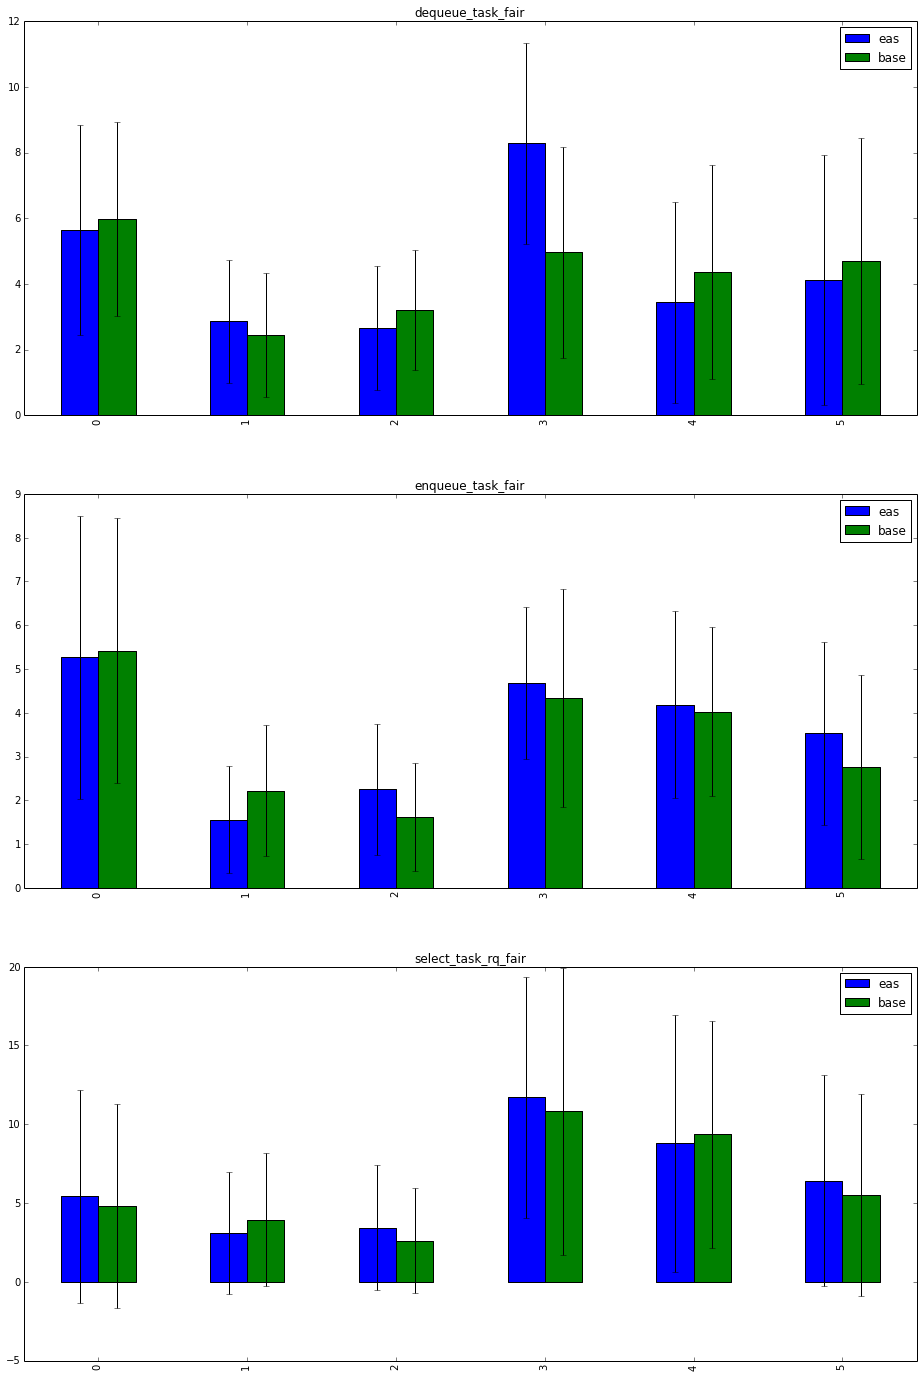

In [15]:
def plot_all_functions(df):
    functions = df.index.get_level_values(2).unique()
    fcount = len(functions)

    fig, pltaxes = plt.subplots(fcount, 1, figsize=(16, 8*fcount))

    fig_id = 0
    for fname in functions:
        logging.info("Plotting stats for [%s] function", fname)
        if fcount > 1:
            axes = pltaxes[fig_id]
        else:
            axes = pltaxes
        plot_stats(df, fname, axes)
        fig_id = fig_id + 1
        
plot_all_functions(stats_df)